(NOTE: In the following example the noise is very large compared to the signal! This is a pure academic example.)

We assume our process can be represented by a 2D integrated random walk, i.e.
$$\ddot x(t) = 0 + W_x(t) \qquad \ddot y(t) = 0 + W_y(t)$$
The we know (from the lectures and exercises) that the state transition matrix and the process noise matrix can be analytically expressed (assuming that $W_x$ and $W_y$ have the same stochastic properties) 

In [421]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

def Phi(dt):
    return np.matrix([[1, dt, 0,0], [0, 1, 0,0], [0, 0, 1,dt], [0,0,0,1]])    

def Q(sigma,dt):
    return sigma*sigma*np.matrix([[dt**3/3.0, dt**2/2.0, 0,0], [dt**2/2.0, dt, 0,0],\
                            [0, 0, dt**3/3.0,dt**2/2.0], [0,0,dt**2/2.0,dt]])   


Let's generate the true "trajectory" which we actually want to figure out


In [422]:
N=100
time_array=np.arange(0,N)
xpos_true=time_array/N*5

#case 1: linear drive
#case 2: sine path
#case 3: a sharp turn
case = 3

if case == 1:
    ypos_true=time_array/N*5

if case ==2:
    ypos_true=np.sin(time_array/40)*3

if case ==3:
    xpos_true=time_array/N*10
    xpos_true[int(N/2):]=xpos_true[int(N/2)]
    ypos_true=np.zeros(N)
    ypos_true[int(N/2):]=xpos_true[0:int(N/2)]



assume now we observe at every epoch $x$ and $y$ but they are both noisy (std. dev. 0.01)

In [423]:
xpos_obs=xpos_true+np.random.randn(N)*0.01
ypos_obs=ypos_true+np.random.randn(N)*0.01

In the forward run we get

In [424]:
#start with a random state
xnn=np.array([[np.random.randn()*0.1],[0],[np.random.randn()*0.1],[0]])
#since we don't know much about our state we make its covariance pretty large
Pnn=np.eye(4,4)*1


x_fwd=[]
P_fwd=[]

#running the filter

#process noise, case 1
if case == 1:
    sigma=0.001

#process noise, case 2
if case == 2:
    sigma=4e-1

#process noise, case 3
if case == 3:
    sigma=1e-4 #start with 1e-3 and then "play"

for i in np.arange(0,N):
    #predict state
    ph=Phi(1)
    xnn_p=ph@xnn
    
    #predict variance
    qq=Q(sigma,1)
    Pnn_p = ph@Pnn@np.transpose(ph)+qq
    
    # get the "observations" 
    z=np.array([[xpos_obs[i]],[ypos_obs[i]]])
    # build the H matrix
    H=np.matrix([[1, 0, 0,0], [0, 0,1 ,0]]) 
    # covariance of the observations
    R=np.eye(2,2)*0.0001
    # compute Kalman gain
    K=Pnn_p@np.transpose(H)@inv(H@Pnn_p@np.transpose(H)+R)
    
    #update the state
    xnn=xnn_p + K@(z-H@xnn_p)
    
    #update the covariance
    Pnn=(np.eye(xnn.size)-K@H)@Pnn_p
    
    #save the results
    x_fwd.append(xnn)
    P_fwd.append(Pnn)

    


Now do the backward run

In [425]:
#start with the last state from the fwd run + some random noise
xnn= x_fwd[-1]+np.array([[np.random.randn()*0.1],[0],[np.random.randn()*0.1],[0]])
#since we don't know much about our state we make its covariance pretty large
Pnn=np.eye(4,4)*1

x_bwd=[]
P_bwd=[]



for i in np.arange(0,N):
    #predict state
    ph=Phi(1)
    xnn_p=ph@xnn
    
    #predict variance
    qq=Q(sigma,1)
    Pnn_p = ph@Pnn@np.transpose(ph)+qq
    
    # get the "observations" 
    z=np.array([[xpos_obs[N-i-1]],[ypos_obs[N-i-1]]])
    # build the H matrix
    H=np.matrix([[1, 0, 0,0], [0, 0,1 ,0]]) 
    # covariance of the observations
    R=np.eye(2,2)*0.0001
    # compute Kalman gain
    K=Pnn_p@np.transpose(H)@inv(H@Pnn_p@np.transpose(H)+R)
    
    #update the state
    xnn=xnn_p + K@(z-H@xnn_p)
    
    #update the covariance
    Pnn=(np.eye(xnn.size)-K@H)@Pnn_p
    
    #save the results
    x_bwd.insert(0,xnn)
    P_bwd.insert(0,Pnn)

Now do the averaging

In [426]:
#some book keeping for later plotting
x_array=np.zeros(N) 
y_array=np.zeros(N) 
sigmax=np.zeros(N) 
sigmay=np.zeros(N) 

x_array_fwd=np.zeros(N) 
y_array_fwd=np.zeros(N) 
sigmax_fwd=np.zeros(N) 
sigmay_fwd=np.zeros(N) 

x_array_bwd=np.zeros(N) 
y_array_bwd=np.zeros(N) 
sigmax_bwd=np.zeros(N) 
sigmay_bwd=np.zeros(N) 


for i in np.arange(0,N):
    P = inv(inv(P_fwd[i]) + inv(P_bwd[i]))
    x= P@(inv(P_fwd[i])@x_fwd[i] + inv(P_bwd[i])@x_bwd[i])
        
    x_array[i]=x[0] # the x-coordinate is on the first position in the state vector
    y_array[i]=x[2] # the y-coordinate is on the third (!) position in the state vector
    sigmax[i]=np.sqrt(P[0,0])
    sigmay[i]=np.sqrt(P[2,2])
    
    x_array_fwd[i]=x_fwd[i][0] 
    y_array_fwd[i]=x_fwd[i][2] 
    sigmax_fwd[i]=np.sqrt(P_fwd[i][0,0])
    sigmay_fwd[i]=np.sqrt(P_fwd[i][2,2])
    
    x_array_bwd[i]=x_bwd[i][0] 
    y_array_bwd[i]=x_bwd[i][2] 
    sigmax_bwd[i]=np.sqrt(P_bwd[i][0,0])
    sigmay_bwd[i]=np.sqrt(P_bwd[i][2,2])   
    

Let's plot what we just did!!!

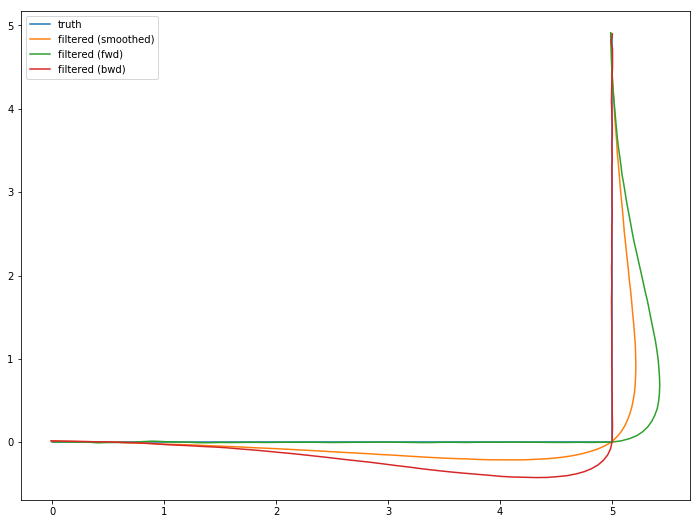

In [427]:
plt.figure(1,figsize=(12, 9))
plt.plot(xpos_true, ypos_true,label='truth')
plt.plot(x_array, y_array,label='filtered (smoothed)')
plt.plot(x_array_fwd, y_array_fwd,label='filtered (fwd)')
plt.plot(x_array_bwd, y_array_bwd,label='filtered (bwd)')
plt.legend()
plt.show()
    

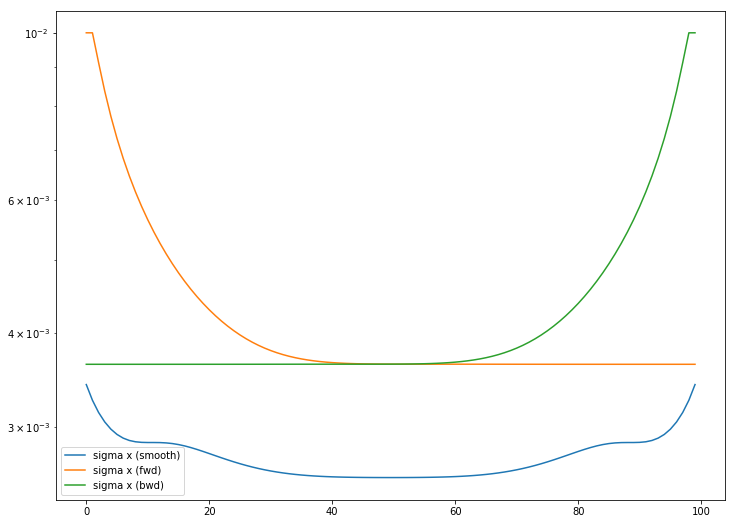

In [428]:
plt.figure(2,figsize=(12, 9))
plt.semilogy(time_array, sigmax,label='sigma x (smooth)')
plt.semilogy(time_array, sigmax_fwd,label='sigma x (fwd)')
plt.semilogy(time_array, sigmax_bwd,label='sigma x (bwd)')
plt.legend()
plt.show()